The following is the notebook of code written by H. Passmore for the assessment and tuning of Machine Learning algorithms for Capstone 1: Amazon Book Reviews & Ratings Predictor. 

# Machine Learning Algorithms for Capstone 1
_Amazon Book Reviews & Ratings Predictor_

_Machine Learning Code_
***

### Below is the code for assessing and tuning machine learning algorithms to predict ratings from reviews.

In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import norm
import numpy as np
import scipy as sp

# Build figures inline
%matplotlib inline

In [2]:
# Setup Pandas  
pd.set_option('display.width', 350)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

In [3]:
# Import scikit-learn tools, vectorizers, transformer, and classifiers
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

# import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# import TfidfTransformer
from sklearn.feature_extraction.text import TfidfTransformer

# import Multinomial Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB

# import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# import Logistic Regression CV Classifier
from sklearn.linear_model import LogisticRegressionCV

# import SVM classifiers
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Import Pipeline 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

In [4]:
# Implement tools to Reduce Document Dimensions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.stem.snowball import SnowballStemmer
import string

In [5]:
# set 'SW' as english stopwords from NLTK and count them
SW = set(stopwords.words('english'))
print('Number of english stopwords', len(SW))

Number of english stopwords 179


In [6]:
# view english stopwords
print(SW)

{'ve', 'yours', 'being', 'ain', 'same', 'too', 'me', 'of', "won't", 'other', 'he', 'how', 'both', 'isn', 'but', 'we', 'shan', 'if', 'wouldn', 'his', 'had', 'did', "mightn't", 'i', "shan't", "weren't", 'haven', 'which', 'down', 'ourselves', "hadn't", 'under', "you've", 'until', 'be', 'm', 'yourself', "mustn't", 'our', 'than', 'herself', 'hasn', "it's", 'what', 'was', 'again', 'in', 'just', 'hadn', 're', 'such', 'myself', 'them', 'with', 'between', 'all', 'most', "shouldn't", 'd', 'doesn', "didn't", 'its', 'where', "isn't", 'were', 'more', 'mightn', "she's", 'does', "you'll", 'why', 'not', 'their', 'you', "you'd", "that'll", 'aren', 'further', "haven't", 'hers', "should've", "you're", "aren't", 'then', "doesn't", 'this', 'shouldn', 'from', "couldn't", 'weren', 'the', 'themselves', 'my', 'on', 'to', 'ma', 'a', 'any', 'by', 'once', 'after', 'because', 'himself', 'up', 'few', 's', 'when', 'into', 'only', 'these', 'am', 'about', 'here', 'over', 'nor', 'doing', "wouldn't", 'is', 'yourselves',

In [7]:
# remove 'not' from set SW
SW.remove('not')
print('Reduced number of stopwords', len(SW))

Reduced number of stopwords 178


In [8]:
# bring the book_revs dataframe into workspace from the inferential statistics code
# load the pickled  DataFrame of Science Textbook Reviews from hard drive in 'rb' mode
import pickle
with open('book_revs_forML.pickle','rb') as f:
    book_revs = pickle.load(f)

### Check dataframe of ratings and review text

In [9]:
# check input data for Machine Learning: reviewText and rating_cat
book_revs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11546 entries, 0 to 11545
Data columns (total 9 columns):
asin           11546 non-null object
overall        11546 non-null int64
reviewText     11546 non-null object
summary        11546 non-null object
five_not5      11546 non-null object
rating_cat     11546 non-null int64
token_count    11546 non-null int64
caps_count     11546 non-null int64
pct_caps       11546 non-null float64
dtypes: float64(1), int64(4), object(4)
memory usage: 811.9+ KB


In [10]:
# keep only what we need
# rating_cat: '0' =  'low' rating, '1' = 'high' rating
rev_rate = book_revs.drop(['asin', 'overall', 'summary', 'five_not5', 'token_count', 'caps_count', 'pct_caps'], axis=1)
rev_rate.head(2)

,reviewText,rating_cat
0,This is a good book for the science nerd and t...,0
1,"If you're a biology/genetics enthusiast, this ...",1


## Preprocess review text to reduce document dimensions

In [11]:
# combine my review-specific stopwords with english stopwords (minus 'not') as a set
user_defined_stop_words = ['book', 'books']

i = SW
j = list(string.punctuation) + user_defined_stop_words

stopwords = set(i).union(j)

In [12]:
# print the combined list of stopwords and punctuation
print(stopwords)

{'ve', 'yours', 'being', 'same', 'too', 'of', 'other', 'he', 'how', 'isn', ']', 'if', 'his', 'did', "mightn't", "shan't", 'i', "weren't", '&', 'haven', 'down', 'ourselves', "hadn't", 'under', 'm', ')', "mustn't", 'our', '}', "it's", 'what', ';', 'in', 'just', '=', '{', 're', 'myself', ',', 'between', 'all', "shouldn't", 'doesn', 'where', 'were', 'mightn', '^', 'does', 'why', '|', "that'll", 'aren', 'further', "haven't", '.', "should've", 'then', 'shouldn', 'from', "couldn't", 'after', '_', 'because', '!', 's', '<', 'only', ':', '`', 'am', '>', 'about', 'here', '\\', 'is', 'didn', 'whom', 'now', 'or', '$', 'before', 'her', 'can', 'as', '?', '%', 'mustn', 'while', 'have', 'above', 'don', 'having', '#', 'against', 'has', 'there', 'him', 't', 'at', 'it', 'o', 'itself', 'needn', 'wasn', 'some', 'those', "needn't", 'that', 'out', 'for', 'y', "wasn't", 'are', '~', 'shan', 'its', 'ain', 'me', "won't", 'both', 'books', 'but', 'we', 'wouldn', '[', 'had', 'which', "you've", 'until', 'be', 'yourse

In [13]:
# define first preprocessor
def preprocess(x):
    letters_only = re.sub('[^a-zA-Z]', ' ', str(x))                  # keep alpha only
    words = letters_only.lower().split()                            # lowercase everything  
    useful_words = [w for w in words if w not in set(stopwords)]    # remove stopwords
    return (' '.join(useful_words))

In [14]:
# apply preprocessor to review text
rev_rate['clean_revs'] = rev_rate['reviewText'].apply(preprocess)
rev_rate.tail()

,reviewText,rating_cat,clean_revs
11541,Definitely a MUST-READ if you are a home cooki...,1,definitely must read home cooking enthusiast w...
11542,Pros: Scientifically informative and solid. Kn...,0,pros scientifically informative solid knowing ...
11543,Real fun to read. For everybody that is inters...,0,real fun read everybody intersted cooking cert...
11544,This book will teach you the chemical secrets ...,0,teach chemical secrets techniques usually used...
11545,I paid more than $30 to buy such a superficial...,0,paid buy superficial trivial made big mistake ...


In [15]:
# instantiate the stemmer
stemmer = SnowballStemmer("english")

In [16]:
# define second preprocessor for tokenization and stemming
def preprocess2(text):
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    tokens = word_tokenize(text)
    stems = [stemmer.stem(t) for t in tokens]
    return stems

In [17]:
# apply second preprocessor to clean_revs
rev_rate['clean_revs'] = rev_rate['clean_revs'].apply(preprocess2)
rev_rate.tail()

,reviewText,rating_cat,clean_revs
11541,Definitely a MUST-READ if you are a home cooki...,1,"[definit, must, read, home, cook, enthusiast, ..."
11542,Pros: Scientifically informative and solid. Kn...,0,"[pros, scientif, inform, solid, know, chemic, ..."
11543,Real fun to read. For everybody that is inters...,0,"[real, fun, read, everybodi, interst, cook, ce..."
11544,This book will teach you the chemical secrets ...,0,"[teach, chemic, secret, techniqu, usual, use, ..."
11545,I paid more than $30 to buy such a superficial...,0,"[paid, buy, superfici, trivial, made, big, mis..."


In [18]:
# clean_revs must be a list of strings for vectorization steps
rev_rate['clean_revs'] = rev_rate['clean_revs'].apply(str)
rev_rate.tail()

,reviewText,rating_cat,clean_revs
11541,Definitely a MUST-READ if you are a home cooki...,1,"['definit', 'must', 'read', 'home', 'cook', 'e..."
11542,Pros: Scientifically informative and solid. Kn...,0,"['pros', 'scientif', 'inform', 'solid', 'know'..."
11543,Real fun to read. For everybody that is inters...,0,"['real', 'fun', 'read', 'everybodi', 'interst'..."
11544,This book will teach you the chemical secrets ...,0,"['teach', 'chemic', 'secret', 'techniqu', 'usu..."
11545,I paid more than $30 to buy such a superficial...,0,"['paid', 'buy', 'superfici', 'trivial', 'made'..."


In [19]:
rev_rate.clean_revs[-9:-1]

11537    ['author', 'good', 'job', 'describ', 'scientif...
11538    ['buy', 'look', 'cookbook', 'recip', 'list', '...
11539    ['receipt', 'perfect', 'excel', 'condit', 'con...
11540    ['fascin', 'explor', 'physic', 'cook', 'writte...
11541    ['definit', 'must', 'read', 'home', 'cook', 'e...
11542    ['pros', 'scientif', 'inform', 'solid', 'know'...
11543    ['real', 'fun', 'read', 'everybodi', 'interst'...
11544    ['teach', 'chemic', 'secret', 'techniqu', 'usu...
Name: clean_revs, dtype: object

## Create X & y, split train and test data sets

In [20]:
# store the feature matrix (X) and response vector (y) 
# uppercase X because it's an m x n matrix
X = rev_rate.clean_revs

# lowercase y because it's a m x 1 vector
y = rev_rate.rating_cat

print(X.shape)
print(y.shape)

(11546,)
(11546,)


In [21]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Show the results of the split
print("X Training set sample size:", (X_train.shape[0]))
print("X Testing set sample size:", (X_test.shape[0]))
print("y Training set sample size:", (y_train.shape[0]))
print("y Testing set sample size:", (y_test.shape[0]))

X Training set sample size: 8659
X Testing set sample size: 2887
y Training set sample size: 8659
y Testing set sample size: 2887


In [22]:
# Double check stratification
print(np.mean(y_train == 0))
print(np.mean(y_test == 0))

0.336412980714
0.336335296155


## Vectorize, fit, output document-term matrix with two vectorizers

In [23]:
# instantiate two vectorizers, do not use stop_words
vect = CountVectorizer(stop_words=None, lowercase=False, analyzer='word', tokenizer=None, 
                       min_df=3, ngram_range=(1, 2)) 
tfidf = TfidfVectorizer(stop_words=None, lowercase=False, min_df=3, ngram_range=(1, 2))

In [24]:
# Apply CountVectorizer ('vect') to stemmed tokens to learn training data vocabulary
# then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train.values)

# examine the document-term matrix
X_train_dtm

<8659x36938 sparse matrix of type '<class 'numpy.int64'>'
	with 595860 stored elements in Compressed Sparse Row format>

In [25]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test.values)
X_test_dtm

<2887x36938 sparse matrix of type '<class 'numpy.int64'>'
	with 184718 stored elements in Compressed Sparse Row format>

In [26]:
# Apply TfidfVectorizer to learn training data vocabulary
# then use it to create a document-term matrix
X_train_tfidf = tfidf.fit_transform(X_train.values)

# examine the document-term matrix
X_train_tfidf

<8659x36938 sparse matrix of type '<class 'numpy.float64'>'
	with 595860 stored elements in Compressed Sparse Row format>

In [27]:
# transform testing data with tfidif vectorizer into document-term matrix
X_test_tfidf = tfidf.transform(X_test.values)
X_test_tfidf

<2887x36938 sparse matrix of type '<class 'numpy.float64'>'
	with 184718 stored elements in Compressed Sparse Row format>

In [28]:
# view current parameters for CountVectorizer 'vect'
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [29]:
# view current parameters for TfidfVectorizer 'tfidf'
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

## Build the simple model with Naive Bayes for baseline and to compare vectorizers

In [30]:
# instantiate scikit-learn's MultinomialNB() classifier to use on CountVec vectors
nb = MultinomialNB(alpha=1, fit_prior=True)

In [31]:
# train the model using X_train_dtm from CountVectorizer (vect)
%time nb.fit(X_train_dtm, y_train)

CPU times: user 17.2 ms, sys: 19.5 ms, total: 36.6 ms
Wall time: 43.2 ms


MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [32]:
# COMPARE TFIDF VECTORIZER
# instantiate scikit-learn's MultinomialNB() classifier to use on tfidf vectors
nbtfidf = MultinomialNB(alpha=1, fit_prior=True) 

In [33]:
# COMPARE TFIDF VECTORIZER
# train the model using X_train_tfidf from TfidfVectorizer
%time nbtfidf.fit(X_train_tfidf, y_train)

CPU times: user 14.2 ms, sys: 2.57 ms, total: 16.8 ms
Wall time: 15 ms


MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [34]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# calculate F1 Score: a weighted average of the precision and recall (est value at 1 and worst score at 0)
metrics.f1_score(y_test, y_pred_class) #score was up to .82 with 'not' removed but down again with min_df=3

0.81231380337636538

In [35]:
# COMPARE TFIDF VECTORIZER
# make class predictions for X_test_dtm
y_pred_tfidf = nbtfidf.predict(X_test_tfidf)

# calculate F1 Score: a weighted average of the precision and recall (est value at 1 and worst score at 0)
metrics.f1_score(y_test, y_pred_tfidf)

0.80633579725448778

In [36]:
# print the confusion matrix from Count Vectorizer
metrics.confusion_matrix(y_test, y_pred_class)

array([[ 495,  476],
       [ 280, 1636]])

Confusions Matrix breakdown for Count Vectorizer with Naive Bayes:
True Positives: 1636 reviews correctly predicted as 'five'
True Negatives: 495 reviews correctly predicted as 'not5'
False Positives: 476 reviews incorrectly predicted to be 'five' but they are 'not5' (Type I error).
False Negatives: 280 reviews incorrectly predicted to be 'not5' but they are 'five' (Type II error).

In [37]:
# COMPARE TFIDF VECTORIZER
# print the confusion matrix from Count Vectorizer
metrics.confusion_matrix(y_test, y_pred_tfidf)

array([[  61,  910],
       [   7, 1909]])

Confusions Matrix breakdown for TFIDF Vectorizer with Naive Bayes:
True Positives: 1909 reviews correctly predicted as 'five'
True Negatives: 61 reviews correctly predicted as 'not5'
False Positives: 910 reviews incorrectly predicted to be 'five' but they are 'not5' (Type I error).
False Negatives: 7 reviews incorrectly predicted to be 'not5' but they are 'five' (Type II error).

Before tuning Naive Bayes parameters with GridSearchCV (below) the TfidfVectorizer with default settings performs poorly assigning review text to high vs low rating categories.

In [38]:
# COMPARE TFIDF VECTORIZER
# calculate predicted probabilities for X_test_tfidf (document-term matrix from TfidfVectorizer)
y_pred_prob_tfidf = nbtfidf.predict_proba(X_test_tfidf)[:, 1]
y_pred_prob_tfidf

array([ 0.89208592,  0.85519454,  0.60892288, ...,  0.96112489,
        0.88263227,  0.92979038])

In [39]:
# calculate predicted probabilities for X_test_dtm (document-term matrix from CountVectorizer)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([ 0.99457259,  0.91868987,  0.19803406, ...,  0.99995244,
        0.99908528,  0.99999971])

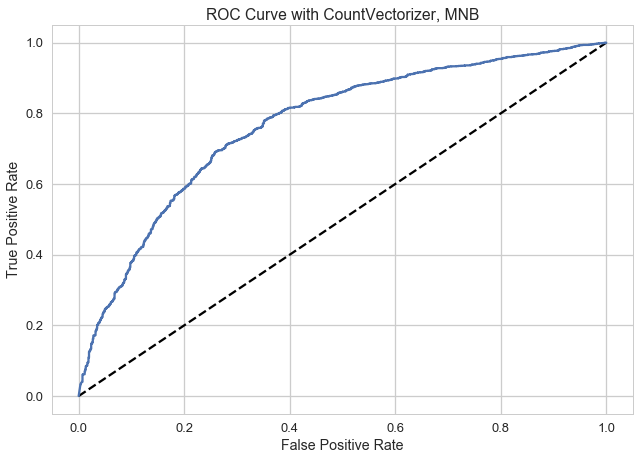

In [40]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve for Naive Bayes with CountVectorizer
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with CountVectorizer, MNB')
plt.show()

In [41]:
# calculate AUC for NB model with CountVect
metrics.roc_auc_score(y_test, y_pred_prob)

0.76802185079196494

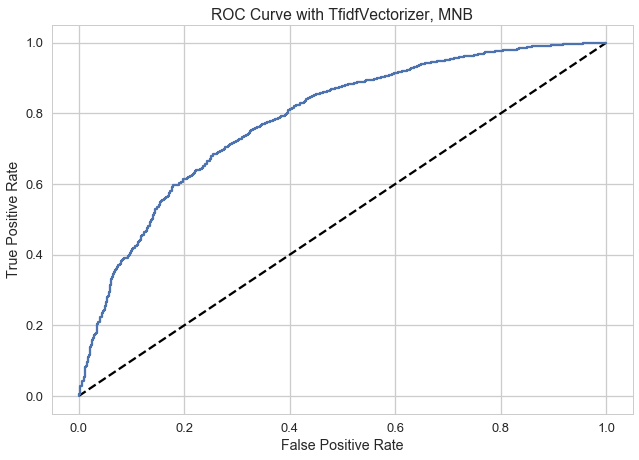

In [42]:
# COMPARE TFIDF VECTORIZER
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_tfidf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with TfidfVectorizer, MNB')
plt.show()

In [43]:
# COMPARE TFIDF VECTORIZER
# calculate AUC for simple model
metrics.roc_auc_score(y_test, y_pred_prob_tfidf)

0.78286702686897047

### Run GridSearchCV on best parameters for CountVectorizer

In [44]:
# create a list of performace parameters for performace tuning (ngram range, use idf?, best alpha)
parameters = {'fit_prior': (True, False),
              #'class_prior': (True, False), 
              'alpha': (0.001, 0.1, 1, 5, 10)
             }

In [45]:
# run this to get a list of the all available pipe-items unique keys for the grid parameters
sorted(nb.get_params().keys())

['alpha', 'class_prior', 'fit_prior']

In [46]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_mnb = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', n_jobs=-1)
gs_mnb = gs_mnb.fit(X_train_dtm, y_train)

In [47]:
# View the best score (set to roc_auc) for MultinomialNB with CountVect
print('Best score for text:', gs_mnb.best_score_) 

Best score for text: 0.762436055907


In [48]:
# Get best parameters for MultinomialNB with CountVect
print('Best parameters:', gs_mnb.best_params_)
# Alpha = 1 is the default and picked as best alpha
# fit_prior: True (default) 

Best parameters: {'alpha': 1, 'fit_prior': True}


In [49]:
# view parameters of grid search multinomial niave bayes model with countvectorizer
gs_mnb

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'fit_prior': (True, False), 'alpha': (0.001, 0.1, 1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

### Run GridSearchCV on best parameters for TfidfVectorizer

In [50]:
# fit grid search again with DTM for tfidf vectorizer (same parameters)
gs_tfidf = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', n_jobs=-1)
gs_tfidf = gs_tfidf.fit(X_train_tfidf, y_train)

In [51]:
# View the best score (set to roc_auc)
print('Best score for text:', gs_tfidf.best_score_) 

Best score for text: 0.777709617489


In [52]:
# Get best parameters
print('Best parameters:', gs_tfidf.best_params_)
# Alpha = 1 is the default and picked as best alpha
# fit_prior: True (default)

Best parameters: {'alpha': 1, 'fit_prior': True}


In [53]:
# view parameters of grid search multinomial niave bayes model with tfidf vectorizer
gs_tfidf

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'fit_prior': (True, False), 'alpha': (0.001, 0.1, 1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

__Interpretation of simple model:__ The Naive Bayes model trained on stemmed tokens with stop words removed performs fairly well. GridSearchCV indicates the best parameters for the two vectorizers are the default Multinomial Naive Bayes parameters. For the rest of the algorithms I will use the document terms matrix from the TfidfVectorizer based on the comparisons above.

## Examine model inputs for further insight

In [54]:
# store the vocabulary of X_train with CountVectorizer
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

36938

In [55]:
# examine the first 50 tokens
print(X_train_tokens[0:50])

['aa', 'aacut', 'aarhus', 'aarhus denmark', 'aaron', 'aaron sach', 'ab', 'abandon', 'abandon resort', 'abbrevi', 'abc', 'abid', 'abil', 'abil bring', 'abil convey', 'abil creat', 'abil explain', 'abil grow', 'abil learn', 'abil make', 'abil predict', 'abil read', 'abil speak', 'abil surviv', 'abil take', 'abil think', 'abil understand', 'abil write', 'abl', 'abl bring', 'abl buy', 'abl come', 'abl convey', 'abl easili', 'abl experi', 'abl explain', 'abl figur', 'abl find', 'abl finish', 'abl follow', 'abl get', 'abl go', 'abl grasp', 'abl identifi', 'abl keep', 'abl learn', 'abl look', 'abl make', 'abl navig', 'abl prove']


In [56]:
# examine the last 50 tokens
print(X_train_tokens[-50:])

['zero', 'zero babylonian', 'zero biographi', 'zero came', 'zero charl', 'zero concept', 'zero develop', 'zero histori', 'zero infin', 'zero infinit', 'zero interest', 'zero introduc', 'zero make', 'zero mathemat', 'zero not', 'zero number', 'zero one', 'zero point', 'zero quot', 'zero realli', 'zero riemann', 'zero seif', 'zero sort', 'zero star', 'zero start', 'zero use', 'zero vacuum', 'zero void', 'zero well', 'zero would', 'zero zero', 'zero zeta', 'zeta', 'zeta function', 'zodiac', 'zone', 'zone also', 'zone come', 'zone demon', 'zone one', 'zone read', 'zone terrifi', 'zoo', 'zoolog', 'zoologist', 'zoom', 'zoonos', 'zoonosi', 'zoonot', 'zoonot diseas']


In [57]:
# Examine features with largest and smallest coefficients from Tfidf/Multinomial NB model
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = nbtfidf.coef_[0].argsort()
print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:25]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-25:-1]]))

Smallest Coefs: 
['err' 'whatev problem' 'put writer' 'believ zero' 'follow fact'
 'follow first' 'loos leaf' 'loos end' 'loos connect' 'look went'
 'threat bioterror' 'look scientif' 'follow scientif' 'disappoint seem'
 'look promis' 'disappoint see' 'follow seem' 'disappoint overal'
 'believ mani' 'look experi' 'lot serious' 'lot stori' 'behavior like'
 'whether lomborg' 'publish trade']

Largest Coefs: 
['read' 'love' 'great' 'not' 'one' 'year' 'inform' 'well' 'use' 'interest'
 'scienc' 'learn' 'like' 'good' 'recommend' 'old' 'understand' 'time'
 'make' 'would' 'way' 'kid' 'help' 'realli']



### Explore False Postive and False Negative classifications with Naive Bayes Classifier

In [58]:
# make class predicitons for X_test_tfidf using gs_tfidf classifier
y_pred_class_tfidf = gs_tfidf.predict(X_test_tfidf)

In [59]:
# use 'y_pred_tfidf' from tfidf/nb for class predictions to view some false positives
FP_set = X_test[y_test < y_pred_class_tfidf]
print(FP_set[0:15])

7803     ['get', 'first', 'chapter', 'bore', 'tear', 'o...
8505     ['pretti', 'cute', 'son', 'realli', 'like', 'l...
11273    ['good', 'son', 'enjoy', 'fairi', 'tale', 'lik...
9554     ['great', 'christma', 'present', 'granddaught'...
9964     ['writer', 'market', 'essenti', 'tool', 'serio...
691      ['hesit', 'rate', 'understood', 'littl', 'enjo...
1967     ['thing', 'suffer', 'great', 'reread', 'thirte...
1004     ['selfish', 'gene', 'perfect', 'layperson', 'w...
8171     ['bruce', 'complet', 'hit', 'mark', 'left', 'w...
6783     ['pythagora', 'said', 'noth', 'can', 'not', 'e...
5463     ['wheaton', 'balanc', 'nice', 'need', 'eager',...
11442    ['order', 'almost', 'month', 'ago', 'still', '...
2785     ['bugliosi', 'prosecutor', 'brief', 'full', 'i...
9089     ['yr', 'old', 'enjoy', 'read', 'word', 'perfec...
1079     ['fair', 'familiar', 'subject', 'found', 'grea...
Name: clean_revs, dtype: object


##### Pick a few False Negs and False Pos reviews to test classification

In [60]:
# Print text of example False Positive with actual rating category: Review 691
print(rev_rate.reviewText[691], 'Actual rating category', rev_rate.rating_cat[691])
# print predicted probability of review text with naive bayes classifier, tfidf vectorizer
print('Predicted prob, 0, 1:',gs_tfidf.predict_proba(tfidf.transform([rev_rate.clean_revs[691]])))

I hesitated to rate this book as I understood so little. I did enjoy the history of math and the introduction of zero to our mathematical system. Once the book went into actual math, it went over my head. I did like the correlation of zero and infinity. Good for those with a math mind. Actual rating category 0
Predicted prob, 0, 1: [[ 0.27034359  0.72965641]]


In [61]:
# Print text of example False Positive with actual rating category: Review 7518
print(rev_rate.reviewText[7518], 'Actual rating category', rev_rate.rating_cat[7518])
# print predicted probability of review text with naive bayes classifier, tfidf vectorizer
print('Predicted prob, 0, 1:',gs_tfidf.predict_proba(tfidf.transform([rev_rate.clean_revs[7518]])))

Because I love books so much (and because I have relied on them so heavily for information throughout my life), I am always disappointed by a book that promises things it doesn't deliver.  Sadly, this is such a book.  Though the publisher promotes it as "A practical field book...[that]...presents the tools and...basic procedures to multiply strength and ease burdens...", that simply isn't true, in my opinion.  Not even close.  This book is superficial and incomplete, as I should have suspected from the fact that it's less than 50 pages long.  The reader will find no systematic discussion of pulleys, levers, or lines here, but only sketchy text that serves as little more than caption for the many entertaining, but largely unenlightening drawings.  My sense is that if this book has any legitimate role (a possibility of which I am profoundly skeptical), it is as a sort of "coffee table book", the sort of thing a visitor might pick up and browse through while waiting for you to serve them 

In [62]:
# Print text of example False Positive with actual rating category: Review 1779
print(rev_rate.reviewText[1779], 'Actual rating category', rev_rate.rating_cat[1779])
# print predicted probability of review text with naive bayes classifier, tfidf vectorizer
print('Predicted prob, 0, 1:',nbtfidf.predict_proba(tfidf.transform([rev_rate.clean_revs[1779]])))

Unfortunately, the book doesn't quite live up to the title, with its productively shocking sense of inevitability; but it's important a book with this title came out about now, because you really have to say, looking at the world, that we probably don't have the guts or the sense of duty to try and stop this money-grubbing system raping the planet.  And that means we'll be gone soon. Actual rating category 0
Predicted prob, 0, 1: [[ 0.38273255  0.61726745]]


In [63]:
# use 'y_pred_class_tfidf' from grid search above for class predictions to view the seven false negatives
FN_set = X_test[y_test > y_pred_class_tfidf]
print(FN_set[0:10])

1509    ['number', 'eccentr', 'eclect', 'interest', 'w...
6154    ['c', 'mon', 'peopl', 'aczel', 'write', 'infin...
4121    ['want', 'start', 'review', 'els', 'statist', ...
4162    ['interest', 'read', 'danish', 'committe', 'sc...
4040    ['littl', 'year', 'global', 'smear', 'campaign...
4101    ['would', 'like', 'clarifi', 'allison', 'augus...
4181    ['given', 'controversi', 'generat', 'hard', 'a...
Name: clean_revs, dtype: object


In [64]:
# Print text of example False Negative with actual rating category: Review 4040
print(rev_rate.reviewText[4040], 'Actual rating category', rev_rate.rating_cat[4040])
# print predicted probability of review text with naive bayes classifier, tfidf vectorizer
print('Predicted prob, 0, 1:',gs_tfidf.predict_proba(tfidf.transform([rev_rate.clean_revs[4040]])))

In a little over a year, a global smear campaign has attempted to discredit the Danish academic who had the audacity to question the hysterics and distortions of the modern day environmental movement. So threatened were the professional environmental pessimists in academia, NGOs and think tanks by Lomborg's arguments and ideas, they lashed out and viciously attacked him, seeking to destroy his credibility. The attack included a one-sided smear in the pages of Scientific American, protesters throwing pies at him at speaking engagements, and a website ... devoted to discrediting him.The smear has now reached a new low, with the Danish Committees on Scientific Dishonesty (DCSD) playing the 17th Century Catholic Church to Lomborg's heretical Galileo. The DCSD has written a 16-page book report denouncing the Dane for publishing a book that they say falls "within the concept of scientific dishonesty."But the Committees' report is nothing more than a rehashing of the complaints already lodged

In [65]:
# Print text of example False Negative with actual rating category: Review 4181
print(rev_rate.reviewText[4181], 'Actual rating category', rev_rate.rating_cat[4181])
# print predicted probability of review text with naive bayes classifier, tfidf vectorizer
print('Predicted prob, 0, 1:',gs_tfidf.predict_proba(tfidf.transform([rev_rate.clean_revs[4181]])))

Given the controversy generated by this book, it is hard to assess the book without referencing the criticisms piled on it.Many reviewers alluded to the fact that many critical and repudiating reviews of the book were from scientific journals. This on the surface commands credence. However, taking a deeper look into this matter reveals something quite different.The science of the environmental studies, mostly conducted in college campuses and in concert with scientific publications, was virtually taken over by the advocate scientists, whereas the old fashion fact-finding scientists have all been silenced. Lomborg's book is an expos&eacute; on the political agenda of the advocate scientists, their shoddy work and outrageous claims. It is small wonder that loud squeals are heard from the "scientific" community. Their integrity, their competency, and their raison d'tre, no less, are being openly questioned!Reading into some of the refutations (I read a fair number them all, including the 

Three False Postive examples have some words like 'love' and 'enjoy' that may be features associated with 'high' ratings. The False Negative reviews are all very long and have a lot of uncommon words.

In [66]:
# test the current model
print(gs_tfidf.predict_proba(tfidf.transform(['This book is not good. I do not recommend that you ever read it',
                                       'This book is not bad at all. I highly recommend this for anyone'])))

[[ 0.26760864  0.73239136]
 [ 0.48026517  0.51973483]]


In [67]:
# test the current model with more extreme review text
print(gs_tfidf.predict_proba(tfidf.transform(['This is a big disappointing bore. I expected more. Unfortunately I was wrong',
                                       'This book awesome. You should totally read it'])))

[[ 0.42848489  0.57151511]
 [ 0.21397966  0.78602034]]


In [68]:
# test test without 'not' bigrams
print(gs_tfidf.predict_proba(tfidf.transform(['This book is bad. Avoid reading it',
                                       'This book is good. I highly recommend this for everyone'])))

[[ 0.4806043   0.5193957 ]
 [ 0.20571925  0.79428075]]


The text reviews with negation phrases are both assigned to the 'high' rating category where predicted probability is =/> 0.50. All fake review text samples are also assigned to the 'high' category. The current model includes bigrams in the document-terms matrix and we removed 'not' from the list of stopwords. However, the Naive Bayes model does not assign 'not good' to the 'low' review class.

## Fit classifiers with TFIDF Vectorizer

## Fit Random Forest classifier

In [69]:
# classifier with grid search parameters (multiple runs to target best parameters)
rf_clf = RandomForestClassifier(max_features=700, min_samples_leaf=8, 
                                class_weight='balanced').fit(X_train_tfidf, y_train)
# parameters added after GridSearch below
predicted_rf_clf = rf_clf.predict(X_test_tfidf)

metrics.f1_score(y_test, predicted_rf_clf)

0.77902621722846443

In [70]:
# print the confusion matrix 
metrics.confusion_matrix(y_test, predicted_rf_clf)

array([[ 605,  366],
       [ 460, 1456]])

In [71]:
# calculate predicted probabilities
y_pred_prob_rf_clf = rf_clf.predict_proba(X_test_tfidf)[:, 1]
y_pred_prob_rf_clf

array([ 0.66816274,  0.44398242,  0.31194437, ...,  0.82714671,
        0.75899145,  0.78716757])

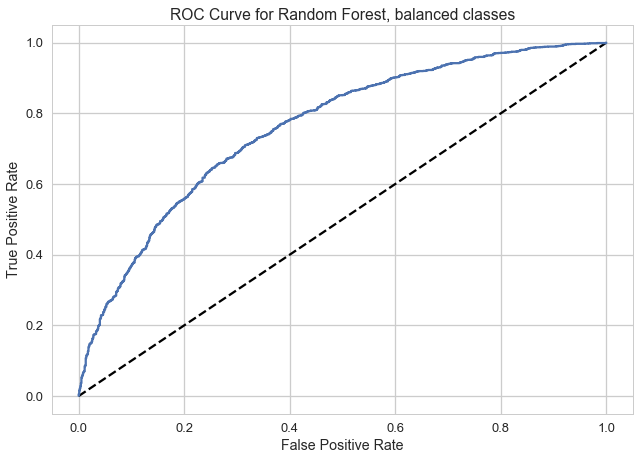

In [72]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf_clf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest, balanced classes')
plt.show()

In [73]:
# calculate AUC for randomforest model
metrics.roc_auc_score(y_test, y_pred_prob_rf_clf)

0.7609898969918879

In [74]:
# find best parameters with GridSearchCV
# create a list of performace parameters for performace tuning (ngram range, use idf?, best alpha)
params = {'max_features': [600, 650, 700, 750],
              'min_samples_leaf': (6, 7, 8, 9),
              #'min_samples_split': (1, 3, 10),
              #'tfidf__use_idf': (True, False), 
              #'mnb__alpha': (0.1, 1, 5, 10)
         }

In [75]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced'), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(X_train_tfidf, y_train) 

In [76]:
# View the best accuracy score
print('Best score for text:', gs_rf.best_score_) 

Best score for text: 0.750068512992


In [77]:
# Get best parameters
print('Best parameters:', gs_rf.best_params_)

Best parameters: {'max_features': 750, 'min_samples_leaf': 7}


In [78]:
# get array of Random Forest feature importances
rf_clf.feature_importances_

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [79]:
import eli5
eli5.show_weights(rf_clf, vec=tfidf, top=20, target_names=y_test)

Weight,Feature
0.0412 ± 0.0501,not
0.0248 ± 0.0397,great
0.0248 ± 0.0518,would
0.0214 ± 0.0192,good
0.0205 ± 0.0290,disappoint
0.0184 ± 0.0319,like
0.0184 ± 0.0315,love
0.0174 ± 0.0295,howev
0.0157 ± 0.0166,read
0.0155 ± 0.0245,much


In [80]:
# test the current model
print(rf_clf.predict_proba(tfidf.transform(['This book is not good. I do not recommend that you ever read it',
                                       'This book is not bad at all. I highly recommend this for anyone'])))

[[ 0.61669559  0.38330441]
 [ 0.53209446  0.46790554]]


In [81]:
# test the current model with more extreme review text
print(rf_clf.predict_proba(tfidf.transform(['This is a big disappointing bore. I expected more. Unfortunately I was wrong',
                                       'This book awesome. You should totally read it'])))

[[ 0.53161833  0.46838167]
 [ 0.33218124  0.66781876]]


In [82]:
# test test without 'not' bigrams
print(rf_clf.predict_proba(tfidf.transform(['This book is bad. Avoid reading it',
                                       'This book is good. I highly recommend this for everyone'])))

[[ 0.43704061  0.56295939]
 [ 0.54523519  0.45476481]]


In [83]:
# False Positive Review tester
print('Review 691 Predicted prob, 0, 1:',rf_clf.predict_proba(tfidf.transform([rev_rate.clean_revs[691]])),
      'actual=0')
print('Review 7518 Predicted prob, 0, 1:',rf_clf.predict_proba(tfidf.transform([rev_rate.clean_revs[7518]])),
      'actual=0')
print('Review 1779 Predicted prob, 0, 1:',rf_clf.predict_proba(tfidf.transform([rev_rate.clean_revs[1779]])),
      'actual=0')
# False Negative Review tester
print('Review 4040 Predicted prob, 0, 1:',rf_clf.predict_proba(tfidf.transform([rev_rate.clean_revs[4040]])),
      'actual=1') 
print('Review 4181 Predicted prob, 0, 1:',rf_clf.predict_proba(tfidf.transform([rev_rate.clean_revs[4181]])),
      'actual=1')

Review 691 Predicted prob, 0, 1: [[ 0.52643082  0.47356918]] actual=0
Review 7518 Predicted prob, 0, 1: [[ 0.81672125  0.18327875]] actual=0
Review 1779 Predicted prob, 0, 1: [[ 0.68723163  0.31276837]] actual=0
Review 4040 Predicted prob, 0, 1: [[ 0.47582884  0.52417116]] actual=1
Review 4181 Predicted prob, 0, 1: [[ 0.70019157  0.29980843]] actual=1


## Fit LogisticRegressionCV classifier

In [84]:
# Logistic Regression CV classifier.
logreg_clf = LogisticRegressionCV(scoring='roc_auc', class_weight='balanced').fit(X_train_tfidf, y_train)

predicted_logreg_clf = logreg_clf.predict(X_test_tfidf)

metrics.f1_score(y_test, predicted_logreg_clf)

0.81567796610169496

In [85]:
# print the confusion matrix 
metrics.confusion_matrix(y_test, predicted_logreg_clf)

array([[ 651,  320],
       [ 376, 1540]])

In [86]:
# calculate predicted probabilities for X_test with stemmed Logistic Regression model
y_pred_prob_logreg_clf = logreg_clf.predict_proba(X_test_tfidf)[:, 1]
y_pred_prob_logreg_clf

array([ 0.82249922,  0.65528285,  0.17260319, ...,  0.90989356,
        0.91937177,  0.90839186])

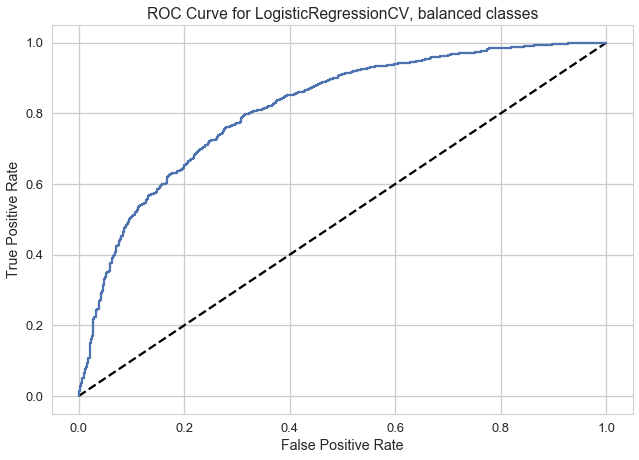

In [87]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_logreg_clf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV, balanced classes')
plt.show()

In [88]:
# calculate AUC for LogisticRegressionCV classifier
metrics.roc_auc_score(y_test, y_pred_prob_logreg_clf)

0.8134012672298323

In [89]:
import eli5
eli5.show_weights(logreg_clf, vec=tfidf, top=20, target_names=y_test)

In [90]:
# view paramaters of logistic regression CV
logreg_clf

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)

In [91]:
# test the current model
print(logreg_clf.predict_proba(tfidf.transform(['This book is not good. I do not recommend that you ever read it',
                                       'This book is not bad at all. I highly recommend this for anyone'])))

[[ 0.52123123  0.47876877]
 [ 0.87880461  0.12119539]]


In [92]:
# test the current model
print(logreg_clf.predict_proba(tfidf.transform(['This is a big disappointing bore. I expected more. Unfortunately I was wrong',
                                       'This book awesome. You should totally read it'])))

[[ 0.82202734  0.17797266]
 [ 0.04213166  0.95786834]]


In [93]:
# test test without 'not' bigrams
print(logreg_clf.predict_proba(tfidf.transform(['This book is bad. Avoid reading it',
                                       'This book is good. I highly recommend this for everyone'])))

[[ 0.91280059  0.08719941]
 [ 0.57488472  0.42511528]]


In [94]:
# False Positive Review tester
print('Review 691 Predicted prob, 0, 1:',logreg_clf.predict_proba(tfidf.transform([rev_rate.clean_revs[691]])),
      'actual=0')
print('Review 7518 Predicted prob, 0, 1:',logreg_clf.predict_proba(tfidf.transform([rev_rate.clean_revs[7518]])),
      'actual=0')
print('Review 1779 Predicted prob, 0, 1:',logreg_clf.predict_proba(tfidf.transform([rev_rate.clean_revs[1779]])),
      'actual=0')
# False Negative Review tester
print('Review 4040 Predicted prob, 0, 1:',logreg_clf.predict_proba(tfidf.transform([rev_rate.clean_revs[4040]])),
      'actual=1') 
print('Review 4181 Predicted prob, 0, 1:',logreg_clf.predict_proba(tfidf.transform([rev_rate.clean_revs[4181]])),
      'actual=1')

Review 691 Predicted prob, 0, 1: [[ 0.71073079  0.28926921]] actual=0
Review 7518 Predicted prob, 0, 1: [[ 0.85882098  0.14117902]] actual=0
Review 1779 Predicted prob, 0, 1: [[ 0.91741366  0.08258634]] actual=0
Review 4040 Predicted prob, 0, 1: [[ 0.7317425  0.2682575]] actual=1
Review 4181 Predicted prob, 0, 1: [[ 0.885303  0.114697]] actual=1


## Fit Support Vector Machines classifier

In [95]:
# try fitting with Support Vector Machines (SVM) algorithm with CountVectorizer (does not work with TFIDFVect)
clf_svm = SGDClassifier(max_iter=5, tol=None, alpha=0.1, random_state=42, class_weight='balanced').fit(X_train_dtm, y_train)
# parameters from GridSearch below
predicted_svm = clf_svm.predict(X_test_dtm)

metrics.f1_score(y_test, predicted_svm)

0.80779498131340111

In [96]:
# print the confusion matrix 
metrics.confusion_matrix(y_test, predicted_svm)

array([[ 654,  317],
       [ 403, 1513]])

In [97]:
# calculate AUC
metrics.roc_auc_score(y_test, predicted_svm)

0.73159920577757043

In [98]:
# apply GridSearchCV

# create a list of performace parameters for performace tuning (ngram range, use idf?, best alpha)
parameters = {'alpha': (1, 0.1, 0.001, 0.0001)}

In [99]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.

gs_svm = GridSearchCV(SGDClassifier(max_iter=5, tol=None, random_state=42, class_weight='balanced'), parameters, n_jobs=-1)
gs_svm = gs_svm.fit(X_train_dtm, y_train)
# cannot set scoring to F1 or roc_auc

In [100]:
# View the best accuracy score
print('Best score for text:', gs_svm.best_score_) 

Best score for text: 0.746275551449


In [101]:
# View the best parameters
print('Best parameters:', gs_svm.best_params_) 
# Best parameters: {'alpha': 0.1}

Best parameters: {'alpha': 0.1}


In [102]:
# view the SVM parameters from grid search
clf_svm

SGDClassifier(alpha=0.1, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [103]:
# test the current model
print(clf_svm.predict(tfidf.transform(['This book is not good. I do not recommend that you ever read it',
                                       'This book is not bad at all. I highly recommend this for anyone'])))

[0 0]


In [104]:
# test the current model
print(clf_svm.predict(tfidf.transform(['This is a big disappointing bore. I expected more. Unfortunately I was wrong',
                                       'This book awesome. You should totally read it'])))

[0 1]


In [105]:
# test test without 'not' bigrams
print(clf_svm.predict(tfidf.transform(['This book is bad. Avoid reading it',
                                       'This book is good. I highly recommend this for everyone'])))

[0 0]


In [106]:
# False Positive Review tester
print('Review 691 Predicted prob, 0, 1:',clf_svm.predict(tfidf.transform([rev_rate.clean_revs[691]])),'actual=0')
print('Review 7518 Predicted prob, 0, 1:',clf_svm.predict(tfidf.transform([rev_rate.clean_revs[7518]])),'actual=0')
print('Review 1779 Predicted prob, 0, 1:',clf_svm.predict(tfidf.transform([rev_rate.clean_revs[1779]])),'actual=0')
# False Negative Review tester
print('Review 4040 Predicted prob, 0, 1:',clf_svm.predict(tfidf.transform([rev_rate.clean_revs[4040]])),'actual=1') 
print('Review 4181 Predicted prob, 0, 1:',clf_svm.predict(tfidf.transform([rev_rate.clean_revs[4181]])),'actual=1')

Review 691 Predicted prob, 0, 1: [0] actual=0
Review 7518 Predicted prob, 0, 1: [0] actual=0
Review 1779 Predicted prob, 0, 1: [0] actual=0
Review 4040 Predicted prob, 0, 1: [0] actual=1
Review 4181 Predicted prob, 0, 1: [0] actual=1


### Adjust classification threshold of best model
* Best classifier is LogisticRegressionCV
* None of the classifiers predict well using .predict
* Better to adjust threshold of best classifier
    * Default threshold is 0.5: 
        * Class 1 predicted if probability > 0.5
        * Class 0 predicted if probability < 0.5
* Instead, find the threshold that gives 0.33 to 0.66 ratio of category 0 to category 1

In [107]:
# Revist the Logistic Regression Confusion Matrix
confusion = metrics.confusion_matrix(y_test, predicted_logreg_clf)
print(confusion)
# [row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[ 651  320]
 [ 376 1540]]


In [108]:
# calculate sensitivity: when the actual value is positive, how often is the prediction correct?
# AKA 'true positive rate', we want to maximize sensitivity
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(y_test, predicted_logreg_clf))

0.80375782881
0.80375782881


In [109]:
# calculate specificity: when the actual value is negative, how often is the prediciton correct?
# how 'specific' or 'selective' is the classifier at predicting positive instances? (Want to maximize)
specificity = TN / (TN + FP)

print(specificity)

0.67044284243


In [110]:
# calculate false positive rate (when actual value is 'low' how often is prediction correct?)
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.32955715757
0.32955715757


In [111]:
# calculate precision: when 'high' rating is predicted, how often is the prediction correct?
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(y_test, predicted_logreg_clf))

0.827956989247
0.827956989247


In [112]:
# focus on F1 Score (it uses both FP & FN)
metrics.f1_score(y_test, predicted_logreg_clf)

0.81567796610169496

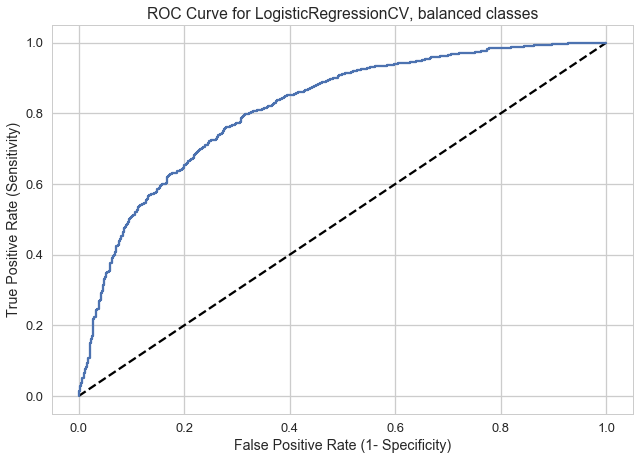

In [113]:
# Revist the ROC curve for the best classifier
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_logreg_clf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (1- Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve for LogisticRegressionCV, balanced classes')
plt.show()

In [114]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [115]:
# evaluate a threshold value. This is the current, default setting
evaluate_threshold(0.5)

Sensitivity: 0.803235908142
Specificity: 0.67044284243


In [116]:
# evaluate a threshold value
evaluate_threshold(0.65)

Sensitivity: 0.622651356994
Specificity: 0.828012358393


In [117]:
# print the first 10 predicted responses
# 1D array (vector) of binary values (0, 1)
logreg_clf.predict(X_test_tfidf)[0:10]

array([1, 1, 0, 1, 1, 0, 0, 0, 1, 1])

In [118]:
# print the first 10 predicted probabilities of class membership
logreg_clf.predict_proba(X_test_tfidf)[0:10]

array([[ 0.17750078,  0.82249922],
       [ 0.34471715,  0.65528285],
       [ 0.82739681,  0.17260319],
       [ 0.37148178,  0.62851822],
       [ 0.31352179,  0.68647821],
       [ 0.63089904,  0.36910096],
       [ 0.83570324,  0.16429676],
       [ 0.95905884,  0.04094116],
       [ 0.36376674,  0.63623326],
       [ 0.41842207,  0.58157793]])

In [119]:
# print the first 10 predicted probabilities for class 1
logreg_clf.predict_proba(X_test_tfidf)[0:10, 1]

array([ 0.82249922,  0.65528285,  0.17260319,  0.62851822,  0.68647821,
        0.36910096,  0.16429676,  0.04094116,  0.63623326,  0.58157793])

In [120]:
# store the predicted probabilities for class 1 (did this above)
y_pred_prob_logreg_clf = logreg_clf.predict_proba(X_test_tfidf)[:, 1]
y_pred_prob_logreg_clf

array([ 0.82249922,  0.65528285,  0.17260319, ...,  0.90989356,
        0.91937177,  0.90839186])

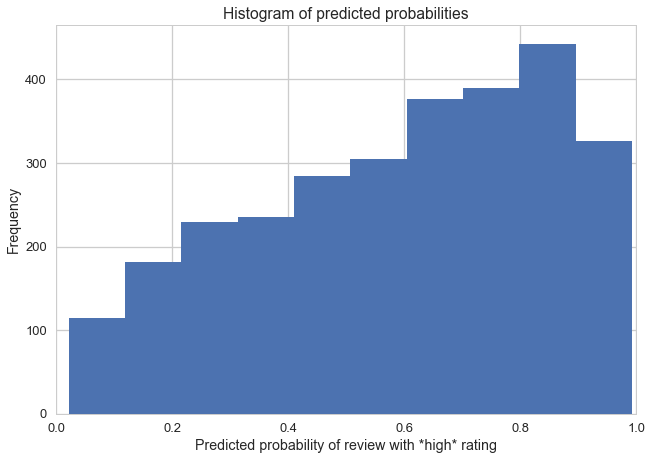

In [121]:
# histogram of predicted probabilities

# 10 bins
plt.hist(y_pred_prob_logreg_clf, bins=10)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of review with *high* rating')
plt.ylabel('Frequency')

* Majority of observations have high probability of a 'high' rating
* Most reviews predicted to be 'high' rated reviews
* Increase the threshold for predicting 'high' ratings
    * Decrease the sensitivity
    * Increase the specificity => increase number of True Negatives

In [122]:
# predict 'high' if the predicted probability is greater than 0.65
from sklearn.preprocessing import binarize
# it will return 1 for all values above 0.65 and 0 otherwise
# results are 2D so we slice out the first column
y_pred_class = binarize(y_pred_prob_logreg_clf.reshape(1,-1), 0.65)[0]
y_pred_class

array([ 1.,  1.,  0., ...,  1.,  1.,  1.])

In [123]:
# print the first 10 predicted probabilities
y_pred_prob_logreg_clf[0:10]

array([ 0.82249922,  0.65528285,  0.17260319,  0.62851822,  0.68647821,
        0.36910096,  0.16429676,  0.04094116,  0.63623326,  0.58157793])

In [124]:
# print the first 10 predicted classes with the lower threshold
y_pred_class[0:10]

array([ 1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.])

In [125]:
# previous confusion matrix (default threshold of 0.5)
print(confusion)

[[ 651  320]
 [ 376 1540]]


In [126]:
# new confusion matrix (threshold of 0.65)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[ 804  167]
 [ 723 1193]]


In [127]:
# calculate sensitivity (used to be  0.80)
print( 1193/ float(1193 + 723))

0.622651356993737


In [128]:
# calculate specificity (used to be  0.67)
print( 804/ float(804 + 167))

0.8280123583934088


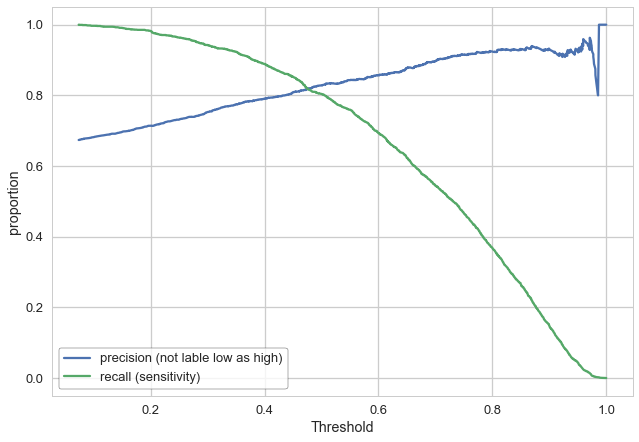

In [129]:
from sklearn.metrics import precision_recall_curve 

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_logreg_clf) 
thresholds = np.append(thresholds, 1) 
#queue_rate = [] 
#for threshold in thresholds: 
#    queue_rate.append((y_pred_prob_logreg_clf >= threshold).mean()) 
plt.plot(thresholds, precision, color=sns.color_palette()[0]) 
plt.plot(thresholds, recall, color=sns.color_palette()[1]) 
#plt.plot(thresholds, queue_rate, color=sns.color_palette()[2]) 
leg = plt.legend(('precision (not lable low as high)', 'recall (sensitivity)'), 
                 frameon=True) 
leg.get_frame().set_edgecolor('k') 
plt.xlabel('Threshold') 
plt.ylabel('proportion')

In [130]:
# False Positive Review tester
print('Review 691 Predicted prob, 0, 1:',logreg_clf.predict_proba(tfidf.transform([rev_rate.clean_revs[691]])),
      'actual=0, adjusted threshold=0')
print('Review 7518 Predicted prob, 0, 1:',logreg_clf.predict_proba(tfidf.transform([rev_rate.clean_revs[7518]])),
      'actual=0, adjusted threshold=0')
print('Review 1779 Predicted prob, 0, 1:',logreg_clf.predict_proba(tfidf.transform([rev_rate.clean_revs[1779]])),
      'actual=0, adjusted threshold=0')
# False Negative Review tester
print('Review 4040 Predicted prob, 0, 1:',logreg_clf.predict_proba(tfidf.transform([rev_rate.clean_revs[4040]])),
      'actual=1, adjusted threshold=0') 
print('Review 4181 Predicted prob, 0, 1:',logreg_clf.predict_proba(tfidf.transform([rev_rate.clean_revs[4181]])),
      'actual=1, adjusted threshold=0')

Review 691 Predicted prob, 0, 1: [[ 0.71073079  0.28926921]] actual=0, adjusted threshold=0
Review 7518 Predicted prob, 0, 1: [[ 0.85882098  0.14117902]] actual=0, adjusted threshold=0
Review 1779 Predicted prob, 0, 1: [[ 0.91741366  0.08258634]] actual=0, adjusted threshold=0
Review 4040 Predicted prob, 0, 1: [[ 0.7317425  0.2682575]] actual=1, adjusted threshold=0
Review 4181 Predicted prob, 0, 1: [[ 0.885303  0.114697]] actual=1, adjusted threshold=0


#### Explore classification threshold values

In [131]:
# use array of class probabilities from logistic regression classifer 'y_pred_prob_logreg_clf'
# use precison_recall_curve ouputs from above:
# precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_logreg_clf) 
# define function "adjusted_classes" to return modified version of y_pred_prob_logreg_clf with different thresholds
def adjusted_classes(y_pred_prob_logreg_clf, t):
    """
    This function adjusts class probabilities based on the prediction threshold (t).
    Functions modified from: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
    """
    return [1 if y >=t else 0 for y in y_pred_prob_logreg_clf]

def precision_recall_threshold(precision, recall, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes function above
    # and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_pred_prob_logreg_clf, t)
    print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_adj),
                      columns=['pred_neg', 'pred_pos'],
                      index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(5,5))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(recall, precision, color='b', alpha=0.2,
            where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall (sensitivity; TP / (FN + TP))');
    plt.ylabel('Precision (TP / (TP + FP))');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(recall[close_default_clf], precision[close_default_clf], '^', c='k',
             markersize=15)

     pred_neg  pred_pos
neg       651       320
pos       376      1540


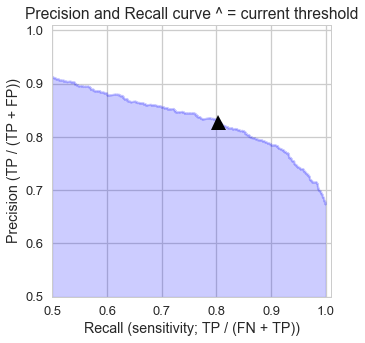

In [132]:
# default threshold
precision_recall_threshold(precision, recall, thresholds, 0.50)

     pred_neg  pred_pos
neg       219       752
pos        34      1882


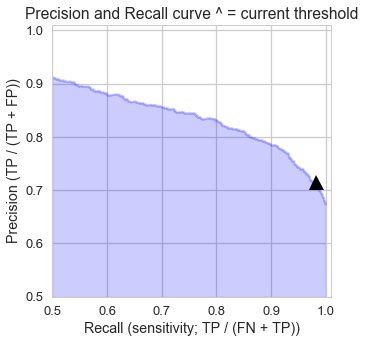

In [133]:
# low threshold 0.20
precision_recall_threshold(precision, recall, thresholds, 0.20)

     pred_neg  pred_pos
neg       294       677
pos        70      1846


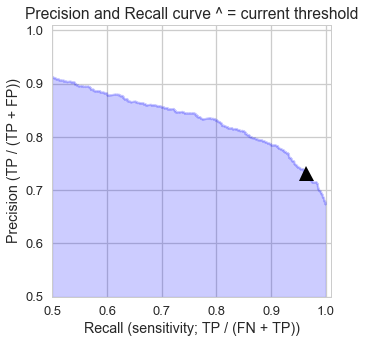

In [134]:
# low threshold 0.25
precision_recall_threshold(precision, recall, thresholds, 0.25)

     pred_neg  pred_pos
neg       379       592
pos       110      1806


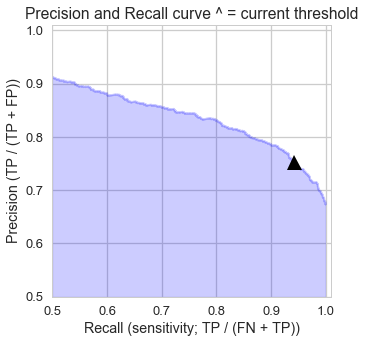

In [135]:
# low threshold 0.30
precision_recall_threshold(precision, recall, thresholds, 0.30)

     pred_neg  pred_pos
neg       521       450
pos       213      1703


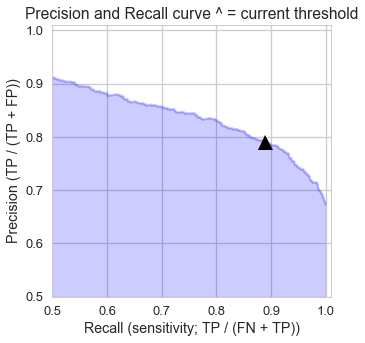

In [136]:
# low threshold 0.40
precision_recall_threshold(precision, recall, thresholds, 0.40)

     pred_neg  pred_pos
neg       750       221
pos       588      1328


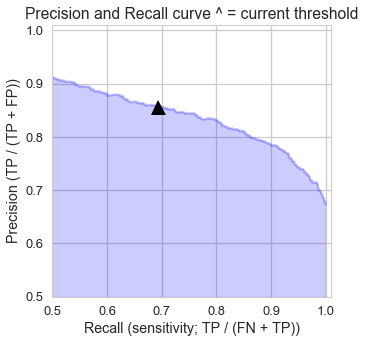

In [137]:
# high threshold 0.60
precision_recall_threshold(precision, recall, thresholds, 0.60)

     pred_neg  pred_pos
neg       804       167
pos       723      1193


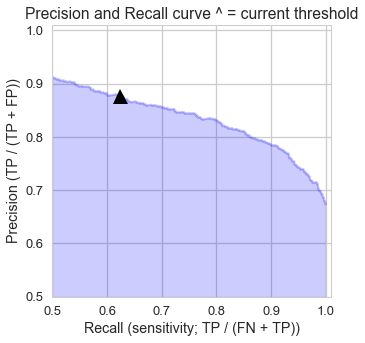

In [138]:
# high threshold 0.65
precision_recall_threshold(precision, recall, thresholds, 0.65)

     pred_neg  pred_pos
neg       851       120
pos       873      1043


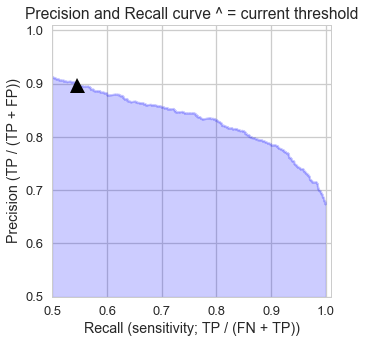

In [139]:
# high threshold 0.70
precision_recall_threshold(precision, recall, thresholds, 0.70)

### Can we improve parameterization of models with Pipelines?
#### Pipeline with CountVectorizer, TfidfTransformer, MultinomialNB classifier

In [140]:
# Can we do better with a pipeline?
# build pipeline with vectorizer, transformer, classifier
count_vec = CountVectorizer(ngram_range=(1,2))
tf_idf = TfidfTransformer()
clf_mnb = MultinomialNB()

steps = [('count_vec', count_vec),
         ('tf_idf', tf_idf),
         ('clf_mnb', clf_mnb)]

p_grid = [{'count_vec__max_df': [0.3,0.4,0.5], 'count_vec__min_df':[2,3,4]}]

pipeline = Pipeline(steps)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nb_gs = GridSearchCV(pipeline, param_grid=p_grid, cv=skf, scoring='roc_auc', n_jobs=-1)

In [141]:
# view parameters of naive bayes pipeline and grid search
nb_gs

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('count_vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        ...r_tf=False, use_idf=True)), ('clf_mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'count_vec__max_df': [0.3, 0.4, 0.5], 'count_vec__min_df': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [142]:
# Fitting the Naive Bayes model 
nb_gs.fit(X_train, y_train)
y_pred = nb_gs.best_estimator_.predict(X_test)

# View the best score (set to roc_auc) for MultinomialNB with GridSearch
print('Best score for text:', nb_gs.best_score_) 

# View the best parameters
print('Best parameters:', nb_gs.best_params_) 

Best score for text: 0.789585533888
Best parameters: {'count_vec__max_df': 0.5, 'count_vec__min_df': 4}


#### Pipeline with CountVectorizer, TfidfTransformer, SVC classifier

In [143]:
# Build pipeline with Support Vector Machines SVC classifier
count_vec = CountVectorizer()
tf_idf = TfidfTransformer()
clf_SVC = SVC(class_weight='balanced')

steps = [('count_vec', count_vec),
         ('tf_idf', tf_idf),
         ('clf_SVC', clf_SVC)]

p_grid = [{'count_vec__min_df': [4,5,6],
           'clf_SVC__random_state': [42],
           #'clf_SVC__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
           #'clf_SVC__C': [0.1,1,10,100,1000],
           #'clf_SVC__gamma': [0.1,1,10,100,1000]
          }]

pipeline = Pipeline(steps)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_gs = GridSearchCV(pipeline, param_grid=p_grid, cv=skf, scoring='roc_auc', n_jobs=-1)

In [144]:
# Fitting the SVM model 
svm_gs.fit(X_train, y_train)
y_pred_svm = svm_gs.best_estimator_.predict(X_test)

In [145]:
# View the best score (set to roc_auc) for SVC with GridSearch
print('Best score for text:', svm_gs.best_score_) 

# View the best parameters
print('Best parameters:', svm_gs.best_params_) 

Best score for text: 0.770146635216
Best parameters: {'clf_SVC__random_state': 42, 'count_vec__min_df': 4}


#### Pipeline with CountVectorizer, TfidfTransformer, Random Forest classifier

In [146]:
# Testing the Random Forest Classifier on review data 
clf_RFC = RandomForestClassifier()

steps = [('counts', CountVectorizer(min_df=1)),
         ('tf_idf', TfidfTransformer()),
         ('clf_RFC', RandomForestClassifier(random_state=42, class_weight='balanced'))]

pipeline = Pipeline(steps)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
p_grid = [{'counts__min_df': [1,3,5],
           'clf_RFC__n_estimators': [500,600,700], 
           #'clf_RFC__min_samples_leaf': range(1,30),
           #'clf_RFC__min_samples_split': range(2,30)
          }]

rf_gs = GridSearchCV(pipeline, param_grid=p_grid, cv=skf, scoring='roc_auc', n_jobs=-1)

In [147]:
# view random forest grid search parameters
rf_gs

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        str...stimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'counts__min_df': [1, 3, 5], 'clf_RFC__n_estimators': [500, 600, 700]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [148]:
# Fitting the Random Forest Classifier model
rf_gs.fit(X_train, y_train)
y_pred_rf = rf_gs.best_estimator_.predict(X_test)

In [149]:
# View the best score (set to roc_auc) for MultinomialNB with GridSearch
print('Best roc_aucscore for rf model:', rf_gs.best_score_) 

# View the best parameters
print('Best pipeline parameters:', rf_gs.best_params_)
# took a long time to run: Best roc_aucscore for rf model: 0.784793252035
#Best pipeline parameters: {'clf_RFC__n_estimators': 600, 'counts__min_df': 3}

Best roc_aucscore for rf model: 0.79220580241
Best pipeline parameters: {'clf_RFC__n_estimators': 700, 'counts__min_df': 3}
